Stacking Model R^2 value (Train): 0.9876470440157374
Stacking Model R^2 value (Test): 0.9475826946663641


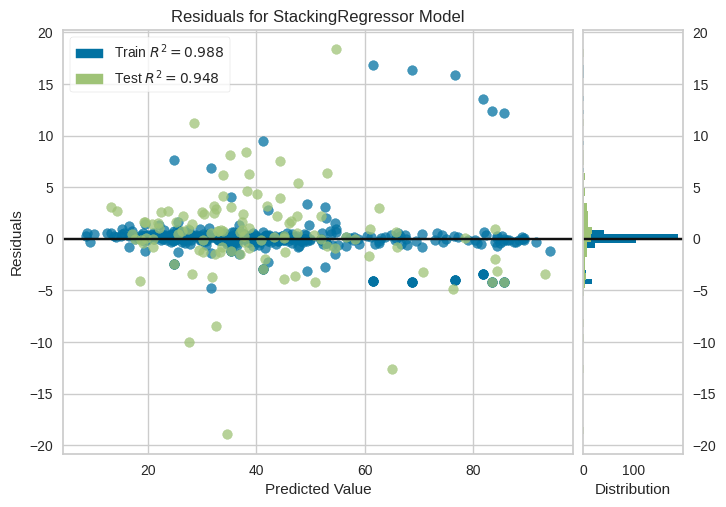

<Figure size 4000x2750 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/ML works/dataset recycled aggregate natural fiber.csv')

# Clean the data by dropping rows with NaN values
df_clean = df.dropna()

# Select features and target, including the 'Fiber Type' feature
X = df_clean[['Cem', 'W/B', 'FA', 'CA',
                  'RCA', 'SCM', 'SP', 'NF',
                  'FT', 'Length', 'Age']]
y = df_clean['CS']

# One-hot encode the 'Fiber Type' feature
X = pd.get_dummies(X, columns=['FT'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
xgb_model = xgb.XGBRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)

# Define the stacking model
stacking_model = StackingRegressor(
    estimators=[('xgb', xgb_model), ('rf', rf_model)],
    final_estimator=LinearRegression(),
    cv=5
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict the compressive strength using the stacking model
y_train_pred = stacking_model.predict(X_train)
y_test_pred = stacking_model.predict(X_test)

# Calculate the R^2 value for the stacking model
stacking_r2_train = r2_score(y_train, y_train_pred)
stacking_r2_test = r2_score(y_test, y_test_pred)
print(f'Stacking Model R^2 value (Train): {stacking_r2_train}')
print(f'Stacking Model R^2 value (Test): {stacking_r2_test}')

# Visualize residuals for the stacking model
stacking_visualizer = ResidualsPlot(stacking_model)
stacking_visualizer.fit(X_train, y_train)
stacking_visualizer.score(X_test, y_test)
plt.figure(dpi=500)
stacking_visualizer.show()

# Prepare data for CSV output with data points
train_data = pd.DataFrame({
    'Data Points (Train)': range(len(y_train)),
    'Observed (Train)': y_train.values,
    'Predicted (Train)': y_train_pred,
    'Error (Train)': y_train.values - y_train_pred
})

test_data = pd.DataFrame({
    'Data Points (Test)': range(len(y_test)),
    'Observed (Test)': y_test.values,
    'Predicted (Test)': y_test_pred,
    'Error (Test)': y_test.values - y_test_pred
})

# Save to CSV
train_data.to_csv('train_predictions_stacking_xgb_rf.csv', index=False)
test_data.to_csv('test_predictions_stacking_xgb_rf.csv', index=False)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

# Mean Absolute Error
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"Mean Absolute Error (Train): {mae_train}")
print(f"Mean Absolute Error (Test): {mae_test}")

# Mean Squared Error
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error (Train): {mse_train}")
print(f"Mean Squared Error (Test): {mse_test}")

# Root Mean Squared Error
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
print(f"Root Mean Squared Error (Train): {rmse_train}")
print(f"Root Mean Squared Error (Test): {rmse_test}")

# Explained Variance Score (which is equivalent to R^2 Score here)
explained_variance_train = explained_variance_score(y_train, y_train_pred)
explained_variance_test = explained_variance_score(y_test, y_test_pred)
print(f"R^2 Score: {explained_variance_train}")
print(f"R^2 Score: {explained_variance_test}")

Mean Absolute Error (Train): 0.8424355464062777
Mean Absolute Error (Test): 2.7213517015430937
Mean Squared Error (Train): 4.769621962400425
Mean Squared Error (Test): 18.155161909557904
Root Mean Squared Error (Train): 2.183946419306212
Root Mean Squared Error (Test): 4.2608874556315035
R^2 Score: 0.9876707671248186
R^2 Score: 0.9481554767584219


100%|██████████| 100/100 [04:05<00:00,  2.45s/it]


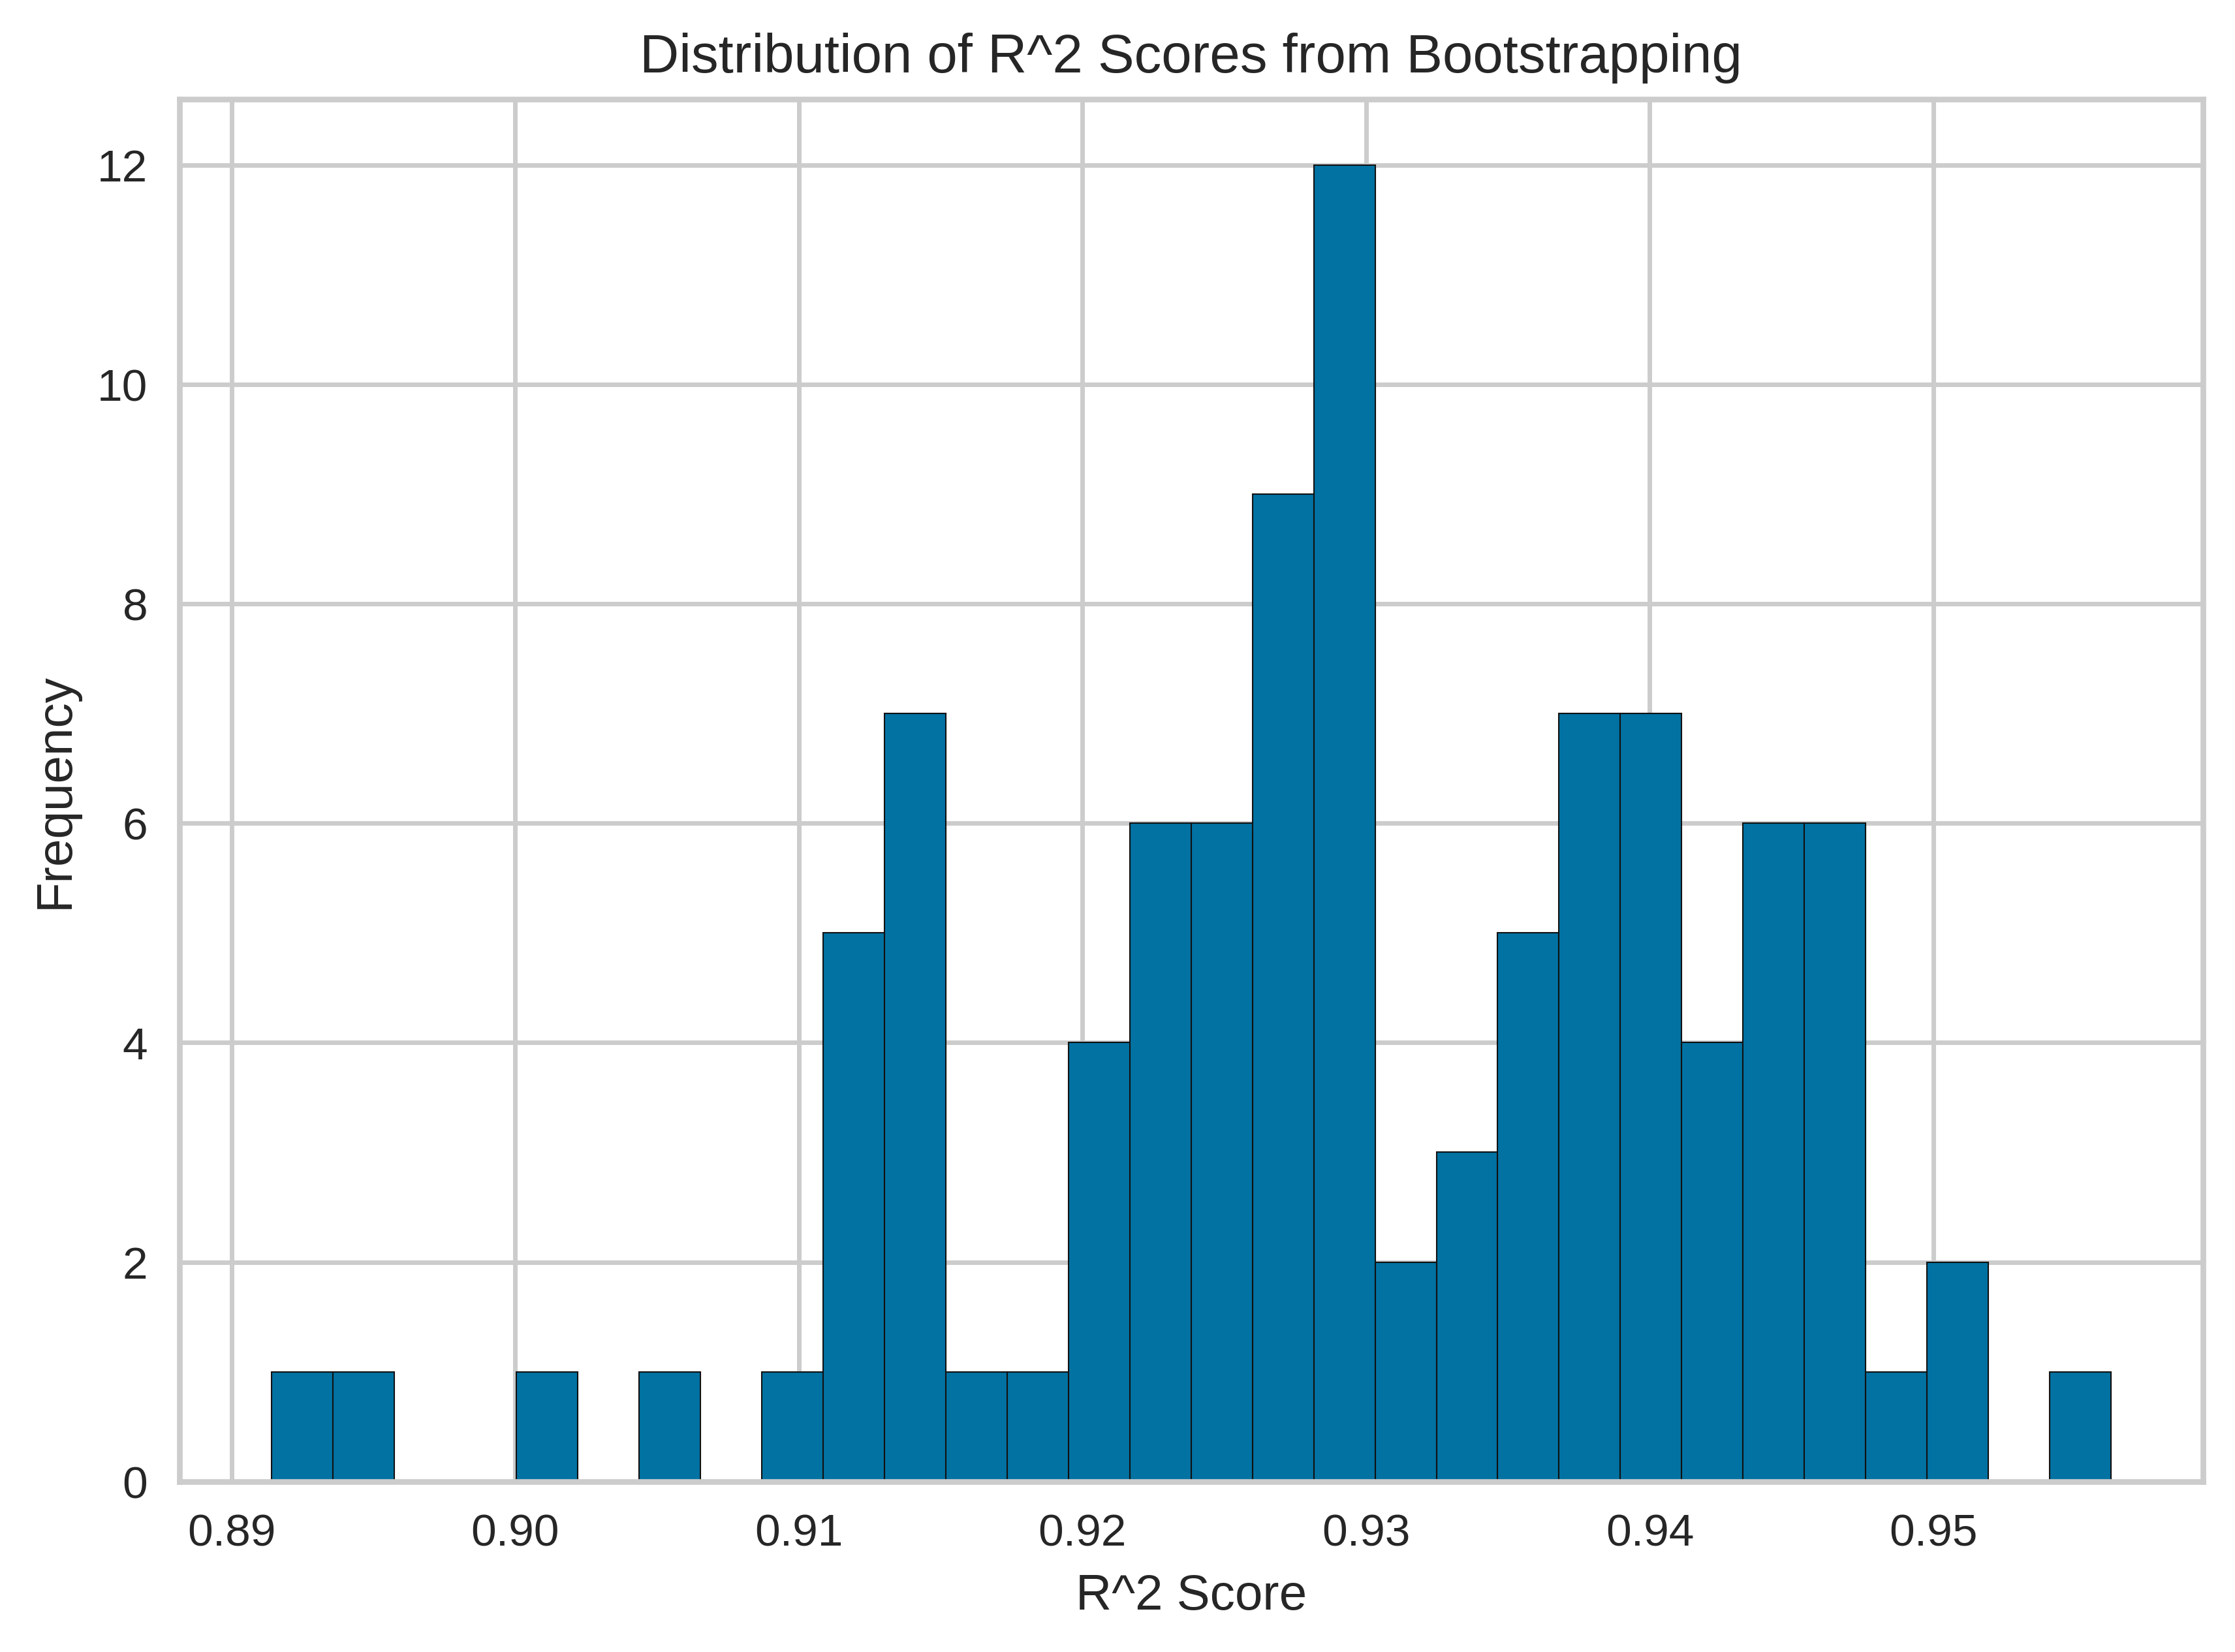

R^2 mean: 0.9296464434931724
R^2 standard deviation: 0.01262572981261484
R^2 95% confidence interval: (0.9049000130604473, 0.9543928739258974)
Uncertainty Percentage: 1.36%


In [ ]:
from sklearn.utils import resample
from tqdm import tqdm
# Uncertainty analysis using bootstrapping
n_iterations = 100  # Number of bootstrap iterations
r2_scores = []

for i in tqdm(range(n_iterations)):
    # Bootstrap sampling
    X_resampled, y_resampled = resample(X_train, y_train, random_state=i)
    stacking_model.fit(X_resampled, y_resampled)
    y_pred = stacking_model.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))

# Plot the distribution of R^2 scores
plt.figure(dpi=500)
plt.hist(r2_scores, bins=30, edgecolor='k')
plt.xlabel('R^2 Score')
plt.ylabel('Frequency')
plt.title('Distribution of R^2 Scores from Bootstrapping')
plt.show()

# Calculate the mean and confidence intervals
r2_mean = np.mean(r2_scores)
r2_std = np.std(r2_scores)
confidence_interval = (r2_mean - 1.96 * r2_std, r2_mean + 1.96 * r2_std)

# Calculate the uncertainty percentage
uncertainty_percentage = (r2_std / r2_mean) * 100

# Print the uncertainty values
print(f'R^2 mean: {r2_mean}')
print(f'R^2 standard deviation: {r2_std}')
print(f'R^2 95% confidence interval: {confidence_interval}')
print(f'Uncertainty Percentage: {uncertainty_percentage:.2f}%')